In [103]:
import pandas as pd
import numpy as np
import random

from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.problems import get_problem
from pymoo.optimize import minimize

# Algoritmo Genético

In [104]:
def generate_instance(row, w):
    new_instance = sum(row*w)
    return new_instance

def generate_feature(individual, database):
    new_feature = [generate_instance(instance, individual) for instance in database]
    return new_feature


In [105]:
def load_happy_detector():
    label_encoder = preprocessing.LabelEncoder()

    df = pd.read_csv('happy_unhappy.csv')
    df = df.dropna()

    # The data is already normalized

    # cat = df.select_dtypes(exclude=['number'])
    # for col in cat.columns:
    #     df[col] = label_encoder.fit_transform(df[col])

    df = df.to_numpy()
    target = df[:, 6]
    data = df[:, 0:-1]

    dataset = {'target': target,
               'data': data,
               'info': 'https://www.kaggle.com/datasets/priyanshusethi/happiness-classification-dataset',
               'date_access': '2023-10-29'}

    return dataset

In [106]:
df = load_happy_detector()
display(df)

{'target': array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0], dtype=int64),
 'data': array([[3, 3, 3, 4, 2, 4],
        [3, 2, 3, 5, 4, 3],
        [5, 3, 3, 3, 3, 5],
        [5, 4, 3, 3, 3, 5],
        [5, 4, 3, 3, 3, 5],
        [5, 5, 3, 5, 5, 5],
        [3, 1, 2, 2, 1, 3],
        [5, 4, 4, 4, 4, 5],
        [4, 1, 4, 4, 4, 4],
        [4, 4, 4, 2, 5, 5],
        [3, 2, 3, 3, 2, 3],
        [4, 4, 3, 4, 4, 4],
        [5, 2, 4, 5, 5, 5],
        [4, 2, 4, 5, 4, 3],
        [4, 1, 3, 3, 4, 3],
        [3, 2, 4, 3, 4, 4],
        [5, 3, 4, 5, 4, 5],
      

In [107]:
pesos = np.zeros(len(df['data'][0]))
print(pesos)

[0. 0. 0. 0. 0. 0.]


In [108]:
xesq = generate_feature(df['data'], pesos)
print(xesq)
print(len(xesq))

[array([0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0.])]
6


In [109]:
def fitness_function(individual, dataset, target, max_depth=1):
    
    new_feature = generate_feature(individual, dataset)
    decision_tree = tree.DecisionTreeClassifier(max_depth=max_depth)
    decision_tree = decision_tree.fit(np.array(new_feature).reshape(-1,1), target)
    
    leaf_indices = [i for i in range(decision_tree.tree_.node_count) if decision_tree.tree_.children_left[i] == decision_tree.tree_.children_right[i]]
    gini_index = sum(decision_tree.tree_.impurity[leaf_indices]) / len(leaf_indices)
    
    return gini_index

In [110]:
# Initialize population
def initialize_population(population_size, individual_size, lower_bound, upper_bound):
    population = []
    for _ in range(population_size):
        individual = [random.randint(lower_bound, upper_bound) for _ in range(individual_size)]
        population.append(individual)
    return population

In [111]:
# Selection: Tournament selection
def tournament_selection(population, fitness_values, tournament_size):
    selected_parents = []
    for _ in range(len(population)):
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitness = [fitness_values[i] for i in tournament_indices]
        winner_index = tournament_indices[tournament_fitness.index(min(tournament_fitness))]
        selected_parents.append(population[winner_index])
    return selected_parents


In [112]:
# Crossover: Single-point crossover
def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

In [113]:
# Mutation: Randomly change a gene
def mutate(individual, mutation_rate, lower_bound, upper_bound):
    for i in range(len(individual)):
        if random.uniform(0, 1) < mutation_rate:
            individual[i] = random.randint(lower_bound, upper_bound)
    return individual

In [114]:
# Genetic algorithm
def genetic_algorithm(population_size, individual_size, lower_bound, upper_bound, generations, tournament_size, mutation_rate):
    population = initialize_population(population_size, individual_size, lower_bound, upper_bound)

    for generation in range(generations):
        # Evaluate fitness of the population
        fitness_values = [fitness_function(individual, df['data'], df['target']) for individual in population]
                
        # Select parents
        parents = tournament_selection(population, fitness_values, tournament_size)

        # Ensure even number of parents for crossover
        if len(parents) % 2 != 0:
            parents.append(random.choice(parents))

        # Create offspring through crossover
        offspring = []
        for i in range(0, len(parents), 2):
            parent1, parent2 = parents[i], parents[i + 1]
            child1, child2 = crossover(parent1, parent2)
            offspring.extend([child1, child2])

        # Mutate offspring
        mutated_offspring = [mutate(child, mutation_rate, lower_bound, upper_bound) for child in offspring]

        # Replace old population with new population (elitism: keeping the best individual)
        population = mutated_offspring

        # Print the best individual in the current generation
        best_individual = min(population, key=lambda x: fitness_function(x, df['data'], df['target']))
        print(f"Generation {generation + 1}: Best Individual - {best_individual}, Fitness - {fitness_function(best_individual, df['data'], df['target'])}")

    # Return the best individual found
    return min(population, key=lambda x: fitness_function(x, df['data'], df['target']))


In [115]:
population_size = len(df['data'])
individual_size = len(df['data'][0])
lower_bound = -10
upper_bound = 10
generations = 100
tournament_size = 20
mutation_rate = 0.1

best_individual = genetic_algorithm(population_size, individual_size, lower_bound, upper_bound, generations, tournament_size, mutation_rate)
print(f"\nBest Individual Overall: {best_individual}, Fitness: {fitness_function(best_individual, df['data'], df['target'])}")


[1, 9, 8, -3, 9, -7]
6
<class 'list'>
[5, 4, 5, 4, -1, 6]
6
<class 'list'>
[-6, -3, -3, -4, -4, -5]
6
<class 'list'>
[8, 0, -6, 2, -3, -4]
6
<class 'list'>
[6, -7, -6, -7, 2, 9]
6
<class 'list'>
[-7, 10, -2, 10, -8, 8]
6
<class 'list'>
[-8, -10, -2, 10, -1, -10]
6
<class 'list'>
[6, 5, 2, 6, -7, -9]
6
<class 'list'>
[-3, 8, 3, 7, -5, -3]
6
<class 'list'>
[-9, -10, 7, -7, 9, 5]
6
<class 'list'>
[4, 9, -10, -8, 1, -8]
6
<class 'list'>
[-7, 3, 6, 8, -6, 9]
6
<class 'list'>
[10, -10, -5, 9, -9, -9]
6
<class 'list'>
[-1, 1, 4, -6, -1, 0]
6
<class 'list'>
[-4, 3, -5, -6, -4, 4]
6
<class 'list'>
[1, 3, -2, -1, -10, -10]
6
<class 'list'>
[-3, -6, -2, 10, -6, 9]
6
<class 'list'>
[-10, -6, 2, 4, 4, -9]
6
<class 'list'>
[-7, 3, -9, -8, 10, 8]
6
<class 'list'>
[-4, 7, -4, 4, -3, 4]
6
<class 'list'>
[-4, 8, -1, 6, 10, 4]
6
<class 'list'>
[2, -8, -7, -2, 10, -4]
6
<class 'list'>
[-10, 8, -10, 0, -1, 6]
6
<class 'list'>
[0, 0, -1, 5, -8, -3]
6
<class 'list'>
[-8, -8, 2, 4, -2, -1]
6
<class 'list'>
[-

[4, 7, 2, 1, -1, 9]
6
<class 'list'>
[4, 8, 0, 2, -3, 9]
6
<class 'list'>
[4, 7, 2, 1, -1, 9]
6
<class 'list'>
[3, 9, 4, 2, -2, 6]
6
<class 'list'>
[4, 8, 0, -4, -3, 9]
6
<class 'list'>
[4, 8, 0, 2, -3, 9]
6
<class 'list'>
[3, 9, 4, 1, 10, 9]
6
<class 'list'>
[3, 9, 4, 1, -1, -9]
6
<class 'list'>
[3, 9, 4, 1, -1, 9]
6
<class 'list'>
[4, 9, 4, 1, -1, 9]
6
<class 'list'>
[4, 7, 2, 2, -2, 4]
6
<class 'list'>
[4, 7, 2, 2, 7, 6]
6
<class 'list'>
[4, 8, 0, 1, -1, 7]
6
<class 'list'>
[5, 9, 4, 2, -3, 9]
6
<class 'list'>
[4, 8, 4, 1, -1, 9]
6
<class 'list'>
[4, 9, 4, 1, -1, 9]
6
<class 'list'>
[4, 7, 2, 2, -2, 6]
6
<class 'list'>
[4, 7, 9, 2, -2, 6]
6
<class 'list'>
[4, 8, 0, 2, -3, 9]
6
<class 'list'>
[3, 9, 0, 2, -3, 9]
6
<class 'list'>
[4, 8, 0, 2, -3, 9]
6
<class 'list'>
[4, 8, 0, 2, -3, 9]
6
<class 'list'>
[4, 8, 0, 2, -3, 9]
6
<class 'list'>
[4, 4, -3, 1, -1, 9]
6
<class 'list'>
[10, 9, 0, 2, -3, 9]
6
<class 'list'>
[4, 8, 4, 1, -1, 9]
6
<class 'list'>
[4, 9, 4, 1, -2, 6]
6
<class 'list'

KeyboardInterrupt: 

# Árvore de decisão

In [ ]:
df = load_happy_detector()
df_new = load_happy_detector()

aux = pd.DataFrame(df_new['data'])
new_feature = generate_feature(best_individual, df_new['data'])

aux['new_feature'] = new_feature
aux = aux.to_numpy()

df_new['data'] = aux

display(df)
display(df_new)

{'target': array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0], dtype=int64),
 'data': array([[3, 3, 3, 4, 2, 4],
        [3, 2, 3, 5, 4, 3],
        [5, 3, 3, 3, 3, 5],
        [5, 4, 3, 3, 3, 5],
        [5, 4, 3, 3, 3, 5],
        [5, 5, 3, 5, 5, 5],
        [3, 1, 2, 2, 1, 3],
        [5, 4, 4, 4, 4, 5],
        [4, 1, 4, 4, 4, 4],
        [4, 4, 4, 2, 5, 5],
        [3, 2, 3, 3, 2, 3],
        [4, 4, 3, 4, 4, 4],
        [5, 2, 4, 5, 5, 5],
        [4, 2, 4, 5, 4, 3],
        [4, 1, 3, 3, 4, 3],
        [3, 2, 4, 3, 4, 4],
        [5, 3, 4, 5, 4, 5],
      

{'target': array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0], dtype=int64),
 'data': array([[   3,    3,    3, ...,    2,    4,  -90],
        [   3,    2,    3, ...,    4,    3,  -68],
        [   5,    3,    3, ...,    3,    5, -116],
        ...,
        [   5,    3,    3, ...,    4,    5, -114],
        [   4,    3,    3, ...,    4,    5, -105],
        [   5,    3,    2, ...,    5,    5, -111]], dtype=int64),
 'info': 'https://www.kaggle.com/datasets/priyanshusethi/happiness-classification-dataset',
 'date_access': '2023-10-29'}

Teste sem o novo atributo

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['target'], test_size=0.2, random_state=42)

decision_tree = tree.DecisionTreeClassifier(max_depth=5)
decision_tree.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5)

In [ ]:
accuracy1 = decision_tree.score(X_test, y_test)
print("Accuracy:", accuracy1)

Accuracy: 0.5862068965517241


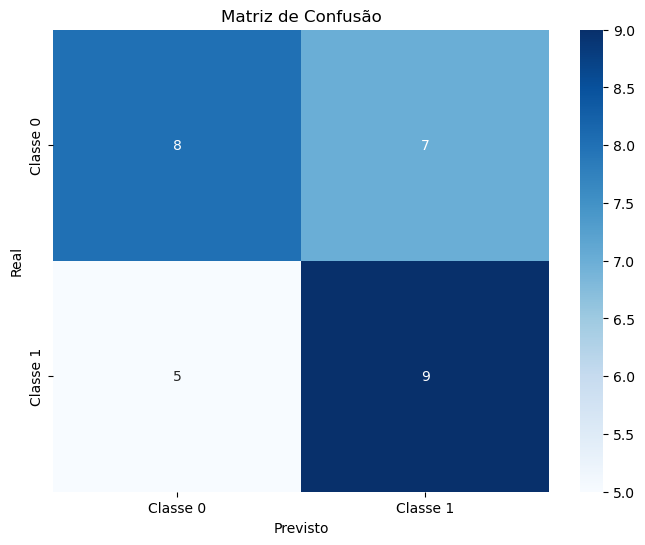

In [ ]:
y_pred = decision_tree.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

Teste com o novo atributo

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_new['data'], df_new['target'], test_size=0.2, random_state=42)

decision_tree = tree.DecisionTreeClassifier(max_depth=5)
decision_tree.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5)

In [ ]:
accuracy2 = decision_tree.score(X_test, y_test)
print("Accuracy:", accuracy2)

Accuracy: 0.6551724137931034


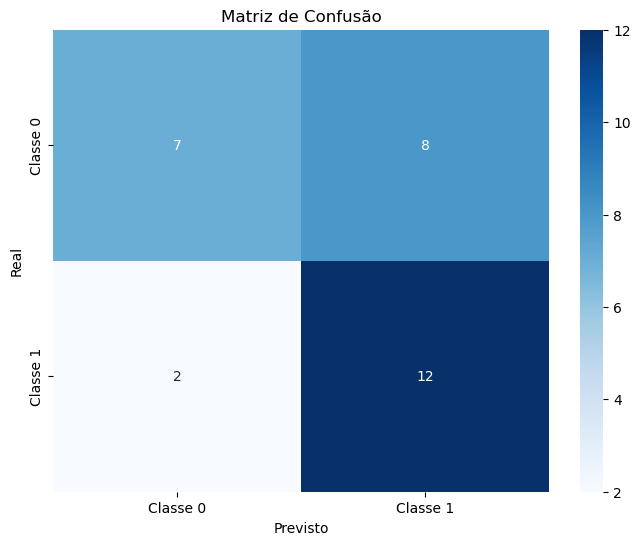

In [ ]:
y_pred = decision_tree.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

Comparação

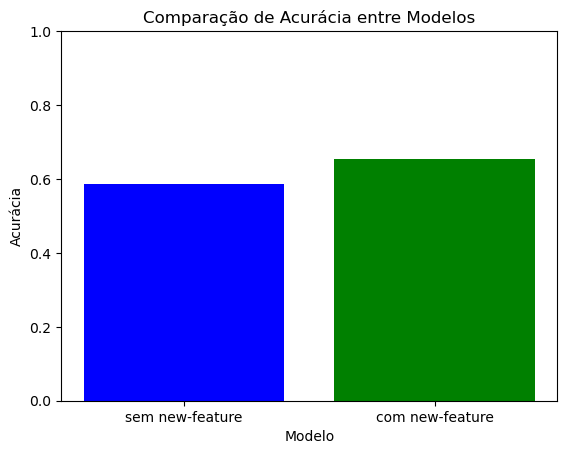

In [ ]:
# Lista de modelos
modelos = ['sem new-feature', 'com new-feature']

# Lista de acurácias
acuracias = [accuracy1, accuracy2]

# Plotar o gráfico de barras
plt.bar(modelos, acuracias, color=['blue', 'green'])
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Limitar o eixo y entre 0 e 1 (intervalo de acurácia)
plt.show()

# Rede Neural

Sem new-feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['target'], test_size=0.2, random_state=42)

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', solver='lbfgs', max_iter=10000, random_state=42)
model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=10000, random_state=42,
              solver='lbfgs')

In [ ]:
val_predictions = model.predict(X_test)
accuracy1 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy1)

Validation Accuracy: 0.5172413793103449


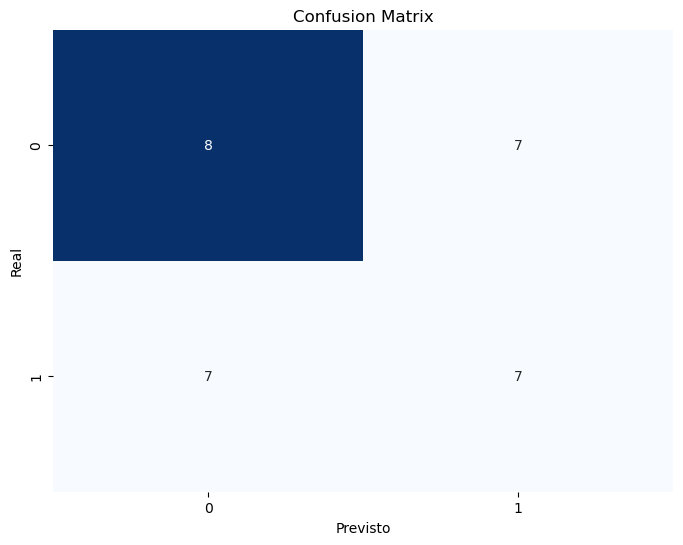

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Step 5: Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

Com new-feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_new['data'], df_new['target'], test_size=0.2, random_state=42)

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', solver='lbfgs', max_iter=10000, random_state=42)
model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=10000, random_state=42,
              solver='lbfgs')

In [ ]:
val_predictions = model.predict(X_test)
accuracy2 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy2)

Validation Accuracy: 0.4482758620689655


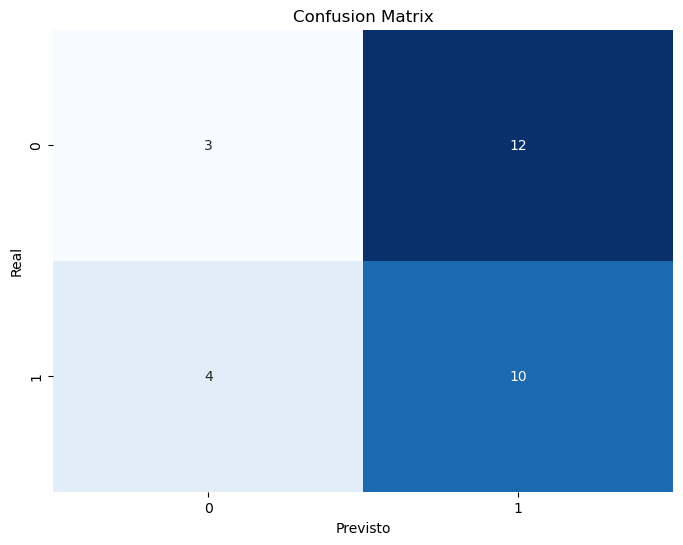

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Step 5: Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

Comparação

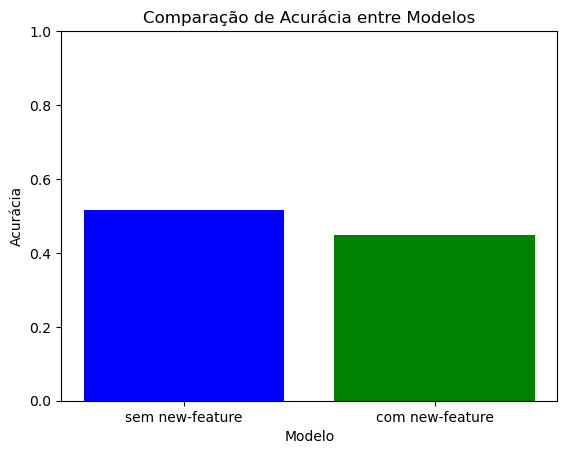

In [ ]:
# Lista de modelos
modelos = ['sem new-feature', 'com new-feature']

# Lista de acurácias
acuracias = [accuracy1, accuracy2]

# Plotar o gráfico de barras
plt.bar(modelos, acuracias, color=['blue', 'green'])
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Limitar o eixo y entre 0 e 1 (intervalo de acurácia)
plt.show()

# Random Forest

Sem new-feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['target'], test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
val_predictions = model.predict(X_test)
accuracy1 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy1)

Validation Accuracy: 0.5517241379310345


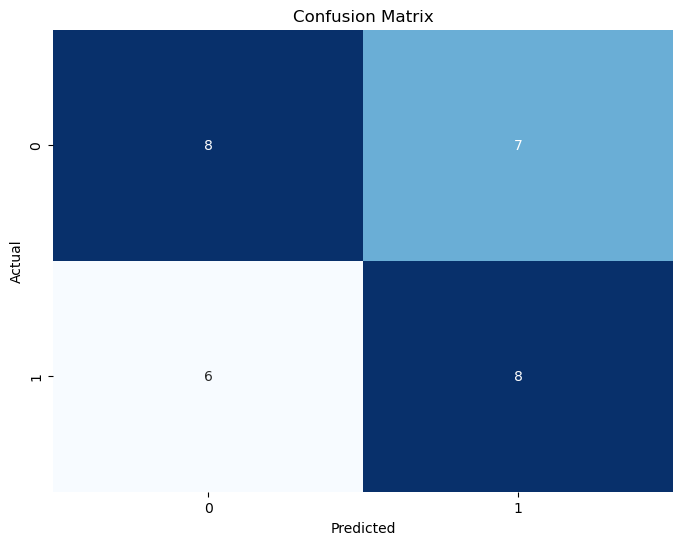

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Com new-feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_new['data'], df_new['target'], test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
val_predictions = model.predict(X_test)
accuracy2 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy2)

Validation Accuracy: 0.5517241379310345


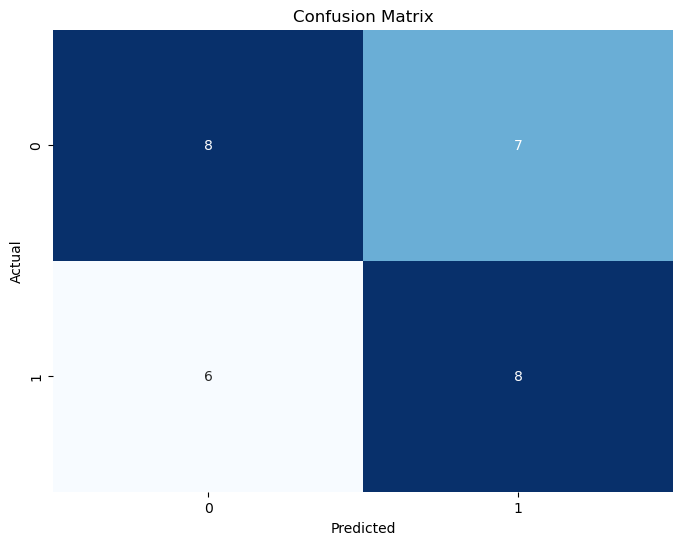

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

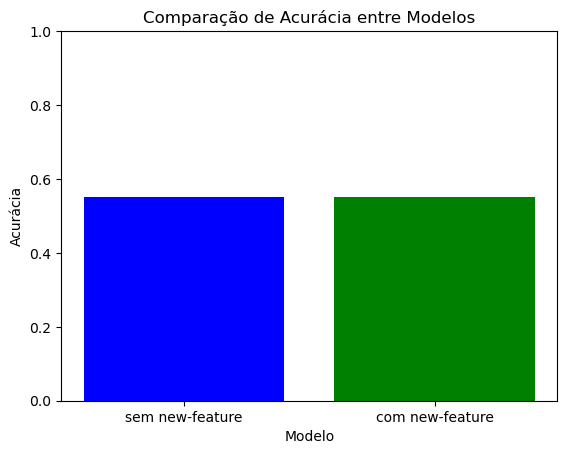

In [ ]:
# Lista de modelos
modelos = ['sem new-feature', 'com new-feature']

# Lista de acurácias
acuracias = [accuracy1, accuracy2]

# Plotar o gráfico de barras
plt.bar(modelos, acuracias, color=['blue', 'green'])
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Limitar o eixo y entre 0 e 1 (intervalo de acurácia)
plt.show()

# SVM

Sem new-feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['target'], test_size=0.2, random_state=42)

In [ ]:
model = SVC(kernel='rbf', random_state=42)
model.fit(X_train, y_train)

SVC(random_state=42)

In [ ]:
val_predictions = model.predict(X_test)
accuracy1 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy1)

Validation Accuracy: 0.5172413793103449


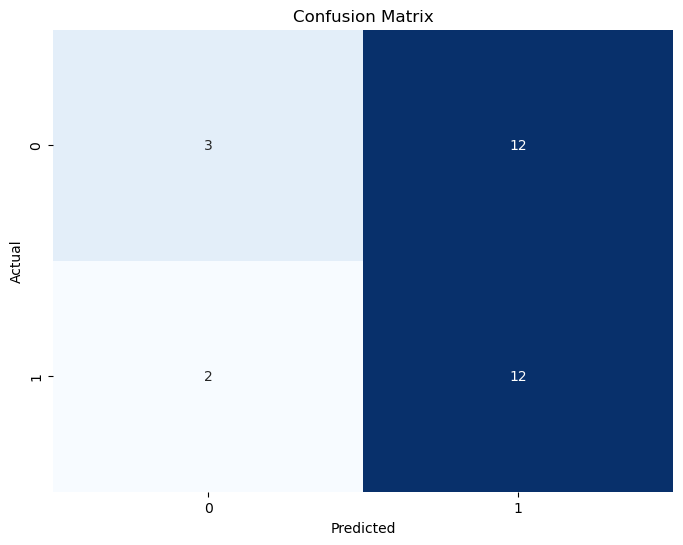

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Com new-feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_new['data'], df_new['target'], test_size=0.2, random_state=42)

In [ ]:
model = SVC(kernel='rbf', random_state=42)
model.fit(X_train, y_train)

SVC(random_state=42)

In [ ]:
val_predictions = model.predict(X_test)
accuracy2 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy2)

Validation Accuracy: 0.5172413793103449


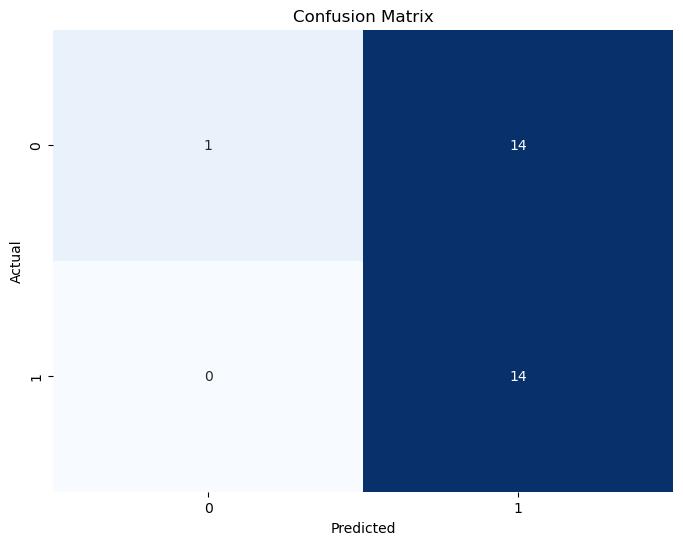

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Comparação

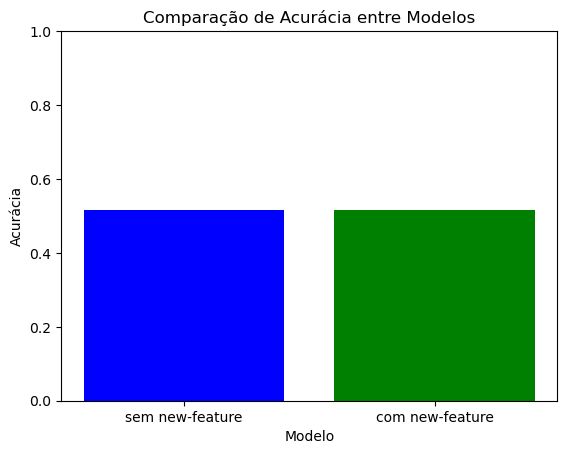

In [ ]:
# Lista de modelos
modelos = ['sem new-feature', 'com new-feature']

# Lista de acurácias
acuracias = [accuracy1, accuracy2]

# Plotar o gráfico de barras
plt.bar(modelos, acuracias, color=['blue', 'green'])
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Limitar o eixo y entre 0 e 1 (intervalo de acurácia)
plt.show()

# Logistic Regression

Sem new-feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['target'], test_size=0.2, random_state=42)

In [ ]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
val_predictions = model.predict(X_test)
accuracy1 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy1)

Validation Accuracy: 0.5517241379310345


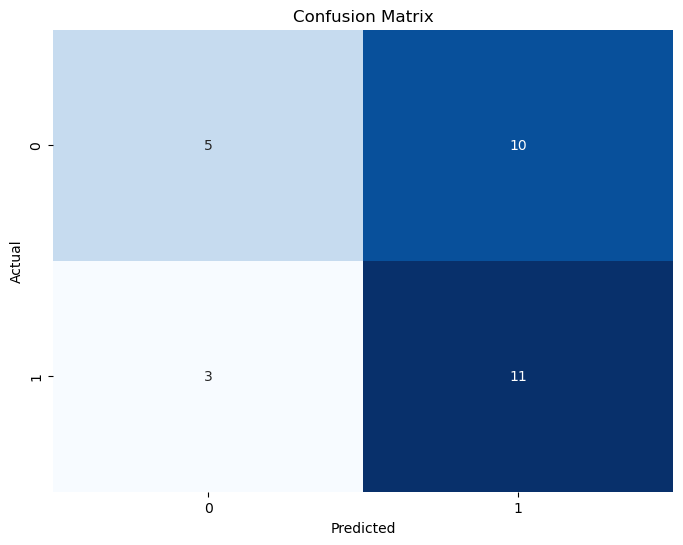

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Com new-feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_new['data'], df_new['target'], test_size=0.2, random_state=42)

In [ ]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
val_predictions = model.predict(X_test)
accuracy2 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy2)

Validation Accuracy: 0.5517241379310345


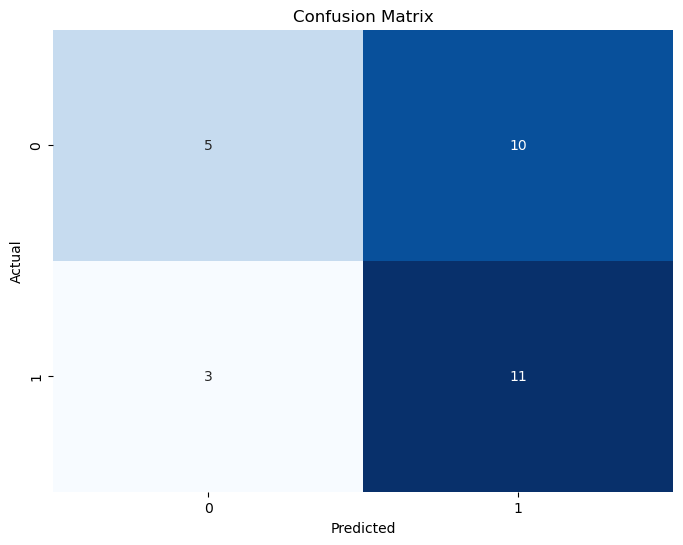

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Comparação

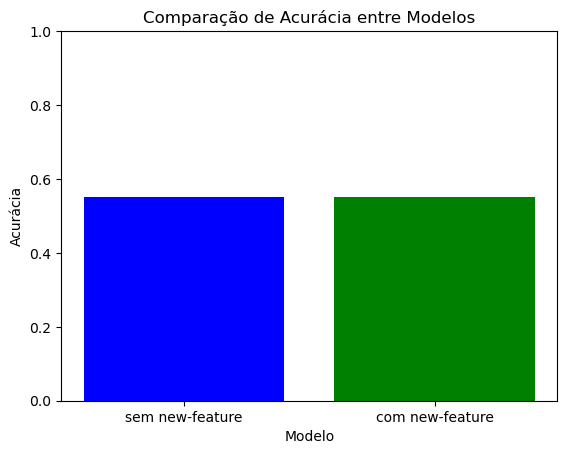

In [ ]:
# Lista de modelos
modelos = ['sem new-feature', 'com new-feature']

# Lista de acurácias
acuracias = [accuracy1, accuracy2]

# Plotar o gráfico de barras
plt.bar(modelos, acuracias, color=['blue', 'green'])
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Limitar o eixo y entre 0 e 1 (intervalo de acurácia)
plt.show()

# XGBoost

Sem new-feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['target'], test_size=0.2, random_state=42)

In [ ]:
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
val_predictions = model.predict(X_test)
accuracy1 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy1)

Validation Accuracy: 0.5517241379310345


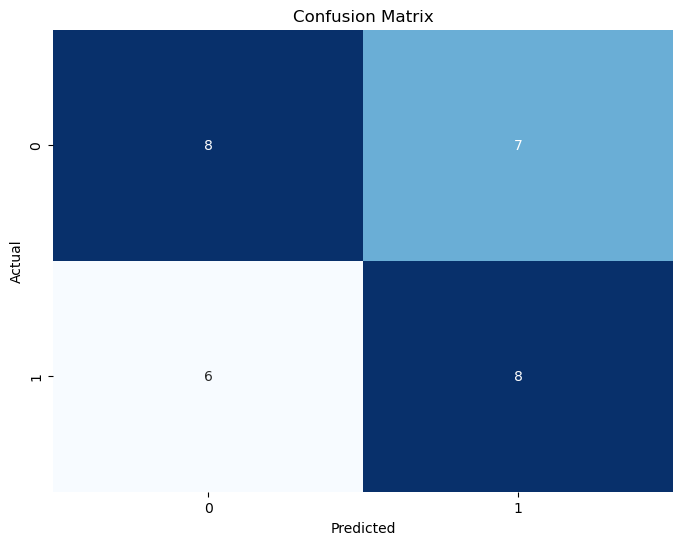

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Com new-feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_new['data'], df_new['target'], test_size=0.2, random_state=42)

In [ ]:
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
val_predictions = model.predict(X_test)
accuracy2 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy2)

Validation Accuracy: 0.5862068965517241


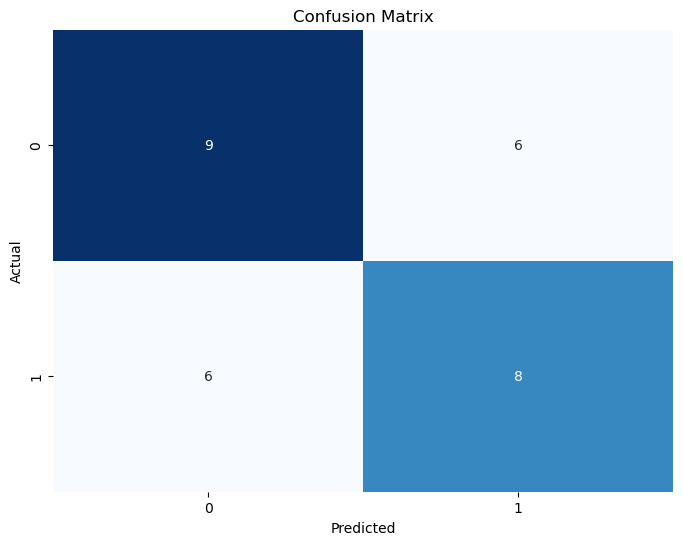

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Comparação

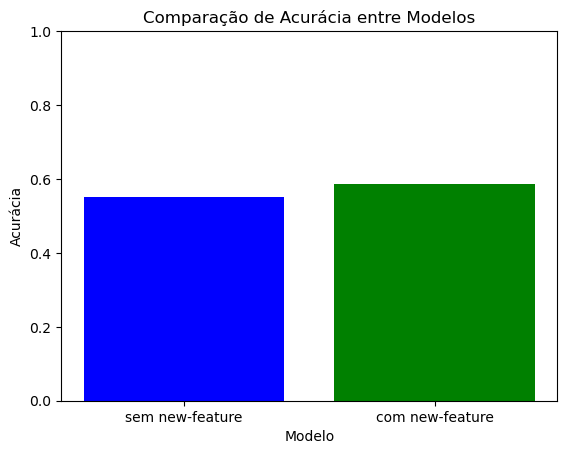

In [ ]:
# Lista de modelos
modelos = ['sem new-feature', 'com new-feature']

# Lista de acurácias
acuracias = [accuracy1, accuracy2]

# Plotar o gráfico de barras
plt.bar(modelos, acuracias, color=['blue', 'green'])
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Limitar o eixo y entre 0 e 1 (intervalo de acurácia)
plt.show()